Title

Description

Importing packages.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing data into pandas DataFrame.

In [16]:
df = pd.read_csv(r"fullDataFinal.csv", index_col=0)
df.columns = df.columns.str.strip()
df.sample(5)

,fire_size_class,latitude,longitude,discovery_month,weekday,Vegetation,remoteness,elevation,Temp,Wind,Humidity,Precipitation
33953,G,62.34090,-161.002400,Jun,True,NaN,0.759810,0.0,12.989656,1.531587,51.430160,0.000000
210,C,34.82717,-95.255000,Feb,True,Broadleaf Forest,0.254984,252.0,6.890374,3.828253,64.521728,16.200000
12056,B,32.73734,-80.707660,Sep,False,Shrubland,0.123981,7.0,25.826576,2.395933,80.549021,195.000000
9285,B,38.42578,-82.816400,Apr,True,NaN,0.139282,261.0,12.212261,2.828967,57.714327,25.833333
1182,B,26.22750,-98.355556,Jun,True,Shrubland,0.290861,43.0,27.580811,5.745526,78.336303,35.700000


Separate target variable (fire_size_class) from predictor variables.

In [18]:
dfTarget = df["fire_size_class"]
dfPredictor = df[["latitude", "longitude", "discovery_month", "weekday", "Vegetation", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]

Before doing anything, let's check the distribution of our data by plotting a histogram

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'remoteness'}>],
       [<AxesSubplot:title={'center':'elevation'}>,
        <AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'Wind'}>],
       [<AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'Precipitation'}>, <AxesSubplot:>]],
      dtype=object)

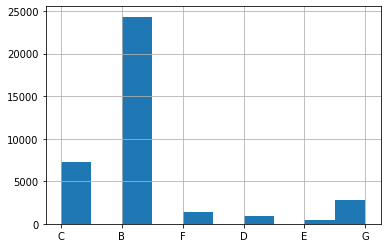

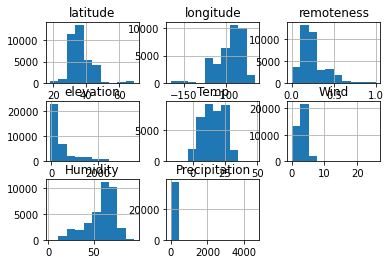

In [19]:
dfTarget.hist()
dfPredictor.hist()

From the first histogram we can see that the "B" class is *way* overrepresented in our data and there is an imbalance.

We'll explore some methods to sort this out after we encode our data properly and create our train and test sets.

Changing categorical variables into one-hot encoded ones.

In [20]:
# First let's do fire_size_class
dfTarget = pd.concat([dfTarget, pd.get_dummies(dfTarget)], axis=1)  # use get_dummies and concatenate the result to dfTarget
dfTarget.drop(["fire_size_class"], axis=1, inplace=True)  # and remove the old column
dfTarget.sample(5)

,B,C,D,E,F,G
2314,1,0,0,0,0,0
12867,1,0,0,0,0,0
32535,1,0,0,0,0,0
4880,1,0,0,0,0,0
15223,1,0,0,0,0,0


In [21]:
# Now Vegetation
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["Vegetation"], prefix="Veg", prefix_sep=" ")], axis=1)
dfPredictor.drop(["Vegetation"], axis=1, inplace=True)

# And discovery_month
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["discovery_month"])], axis=1)
dfPredictor.drop(["discovery_month"], axis=1, inplace=True)

# And weekday
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["weekday"])], axis=1)
dfPredictor.drop(["weekday"], axis=1, inplace=True)
dfPredictor.rename(columns={False:"is_weekend", True:"is_weekday"}, inplace=True)
dfPredictor.sample(5)

,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
14115,38.217486,-120.147232,0.496704,1487.0,13.940353,1.796859,53.752497,6.966667,0,0,...,0,0,1,0,0,0,0,0,0,1
32230,32.599116,-89.122991,0.199767,172.0,25.598414,1.827472,74.079297,40.200000,0,0,...,0,0,0,0,0,0,0,1,0,1
21709,29.610290,-100.007300,0.303593,422.0,27.893955,4.233712,59.409340,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,1
34229,33.367778,-107.951389,0.275043,2401.0,25.351508,3.446856,46.804403,81.066667,1,0,...,0,1,0,0,0,0,0,0,0,1
20093,37.410000,-95.120000,0.252211,261.0,17.077195,1.917328,61.396383,13.166667,0,0,...,0,0,0,0,0,0,1,0,0,1


Scaling numerical data to 0-1 range.

In [22]:
from sklearn.preprocessing import MinMaxScaler

dfPredictorScaled = pd.DataFrame(MinMaxScaler().fit_transform(dfPredictor[["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]), columns=["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"])
# dfPredictorScaled.sample(5)

dfPredictor = dfPredictor.assign(**dfPredictorScaled.to_dict(orient="series"))  # replace the columns of the old df with the ones from the new one
dfPredictor.sample(5)

,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
18730,0.332893,0.695366,0.259901,0.076522,0.416526,0.171620,0.731946,0.023338,1,0,...,0,0,0,1,0,0,0,0,0,1
17664,0.349322,0.669094,0.284060,0.141525,0.341020,0.179169,0.751569,0.004618,0,0,...,0,0,0,0,0,1,0,0,0,1
30944,0.288181,0.693434,0.263226,0.060614,0.683004,0.148743,0.676263,0.002965,0,0,...,0,0,1,0,0,0,0,0,0,1
6356,0.322151,0.852065,0.118069,0.040592,0.429270,0.100095,0.721087,0.004524,1,0,...,0,0,0,1,0,0,0,0,0,1
23021,0.251299,0.660599,0.295509,0.158530,0.668331,0.136756,0.638626,0.000000,0,0,...,0,1,0,0,0,0,0,0,1,0


Make a correlation matrix

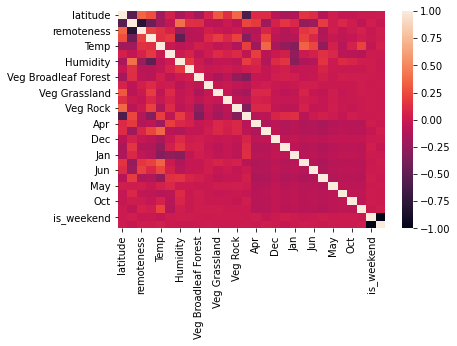

In [9]:
import seaborn as sn

corrMatrix = dfPredictor.corr()
sn.heatmap(corrMatrix)
plt.show()

Train-test split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfPredictor, dfTarget, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)

(33522, 28)
(3725, 28)


In order to fix the distribution of the data when training, we want to change it (in the training set only though).

First, I tried randomly undersampling the data, however that made the training set too small (down to 2.6k samples total). The results were abysmal, with basically every model getting around a 2% accuracy on the test set.

This is the code to do this, in case you want to (but you shouldn't).

    from imblearn.under_sampling import RandomUnderSampler

    rus = RandomUnderSampler()
    X_train, y_train = rus.fit_resample(X_train, y_train.values)

    print(X_train.shape)
    print(y_train.shape)

    y_train = pd.DataFrame(y_train)

Next, I tried the opposite approach -- random *over*sampling.

Here, examples from the smaller classes are picked randomly and repeated in the dataset.

This made the training set massive, at 130k+ samples, but it also made training take forever and didn't achieve great results.

    from imblearn.over_sampling import RandomOverSampler

    ros = RandomOverSampler()
    X_train, y_train = ros.fit_resample(X_train, y_train.values)

    print(X_train.shape)
    print(y_train.shape)

    y_train = pd.DataFrame(y_train)

In [25]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train.values)
y_train = pd.DataFrame(y_train)

d:\pycharmprojects\thesis\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>]], dtype=object)

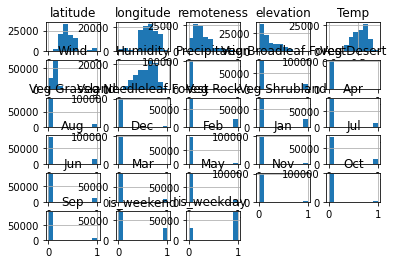

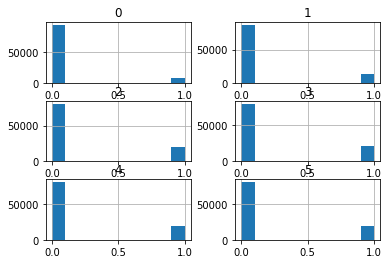

In [26]:
X_train.hist()
y_train.hist()

Make a correlation matrix

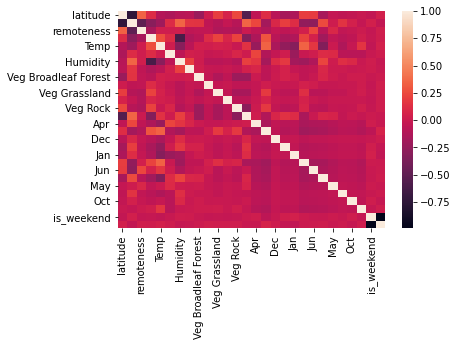

In [27]:
import seaborn as sn

corrMatrix = X_train.corr()
sn.heatmap(corrMatrix)
plt.show()

Training models, each in a cell (?)

* Dummy classifier
* K-Nearest Neighbour (KNN)
* Naïve Bayes (NB)
* Support Vector Machine (SVM)
* Decision Tree (DT)
* Random Forest (RF)
* Gradient Boosted Trees (GBT)
* Multi-Layered Perceptron (MLP)
* Artificial Neural Network (ANN)

Evaluation with confusion matrix, F1 score, etc

### Dummy classifier

In [28]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(X_train, y_train)
training_accuracy = dummy_clf.score(X_train, y_train)
test_accuracy = dummy_clf.score(X_test, y_test)
print(f"Training accuracy: {training_accuracy}")  # 0.6537796074219915
print(f"Test accuracy: {test_accuracy}")  # 0.6502013422818792


Training accuracy: 0.074689461198915
Test accuracy: 0.03946308724832215


### KNN

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(2, 15, 2)}

grid_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid, cv=5)
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))


[0.11218495 0.06924479 0.04433144 0.03450227 0.02878693 0.02482321
 0.0207894 ]
Test set score: 0.34


? seems to be the best on our test set. Let's train that model and save it.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
clf.fit(X_train, y_train)

training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print("Number of neighbors: 9")
print(f"\nTraining accuracy: {training_accuracy}")  # 0.7298490543523656
print(f"\nTest accuracy: {test_accuracy}")  # 0.6934228187919463

### Naive Bayes

In [30]:
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

# train a Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
multi_gnb = MultiOutputClassifier(gnb, n_jobs=-1)
multi_gnb.fit(X_train, y_train)
print(f"GaussianNB train score: {multi_gnb.score(X_train, y_train)}")  # 0.21296462024938845
print(f"GaussianNB test score: {multi_gnb.score(X_test, y_test)}")  # 0.21986577181208053
print("\n")


GaussianNB train score: 0.01326233397059265
GaussianNB test score: 0.005100671140939597




### Support Vector Machine

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

param_grid = {'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1]}

grid_search = GridSearchCV(MultiOutputClassifier(SVC(), n_jobs=-1), param_grid, cv=5)
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

ValueError: Invalid parameter C for estimator MultiOutputClassifier(estimator=SVC(), n_jobs=-1). Check the list of available parameters with `estimator.get_params().keys()`.

Best seems to be with C = ?

Now lets train the final SVM

In [ ]:
svm = SVC(C = 0.25)
multi_svm = MultiOutputClassifier(svm, n_jobs=-1)
multi_svm.fit(X_train, y_train)

print(f"Kernel SVM train score: {multi_svm.score(X_train, y_train)}")  # 0.7018077680329335
print(f"Kernel SVM test score: {multi_svm.score(X_test, y_test)}")  # 0.6977181208053691
print("\n")

### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 40]
# 20:

param_grid = {'max_depth': [2, 4, 8, 16, 32, 64, 128, 256, 512], 'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, )
grid_search.fit(X_train, y_train)
DT_ResultsDf = pd.DataFrame(grid_search.cv_results_)

print(DT_ResultsDf)
print(f"Best test set score: {grid_search.best_score_} with {grid_search.best_params_} parameters.")

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.347367      0.093914         0.023378        0.024774   
1        0.480160      0.003380         0.011188        0.000400   
2        0.861972      0.026711         0.011589        0.000490   
3        1.449067      0.042260         0.013689        0.001396   
4        1.712812      0.049752         0.013687        0.000869   
5        1.711371      0.045952         0.014585        0.002868   
6        1.721813      0.028602         0.013583        0.001016   
7        1.981959      0.356041         0.013586        0.001495   
8        1.714025      0.042461         0.014175        0.001714   
9        0.641189      0.011705         0.010890        0.001281   
10       1.209327      0.039129         0.011990        0.001547   
11       2.403208      0.050523         0.015385        0.002057   
12       3.800699      0.141778         0.014186        0.001325   
13       4.229795      0.080640         0.014186

Best max_depth is 5 -->  0.72060144

In [ ]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

print(f"Decision Tree train score: {dt.score(X_train, y_train)}")  # 0.7240618101545254
print(f"Decision Tree test score: {dt.score(X_test, y_test)}")  # 0.7103355704697987
print("\n")

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [2, 4, 8, 16, 32, 64, 128, 256, 512], 'n_estimators': [10, 100, 1000, 5000], 'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1, warm_start=True), param_grid, cv=5)
grid_search.fit(X_train, y_train)
RF_ResultsDf = pd.DataFrame(grid_search.cv_results_)

print(RF_ResultsDf)
print(f"Best test set score: {grid_search.best_score_} with {grid_search.best_params_} parameters.")

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.931986      0.943220         0.042375        0.004351   
1        2.213349      0.086618         0.264360        0.009675   
2       18.715196      0.098012         2.593686        0.089489   
3       92.192599      0.583681        12.874250        0.617334   
4        0.602364      0.122971         0.066334        0.047368   
..            ...           ...              ...             ...   
67     653.061826     18.741582        21.750120        2.354909   
68       1.928824      0.273057         0.080917        0.058325   
69      13.232246      0.215891         0.572613        0.603446   
70     129.255595      2.218610         2.793139        0.111566   
71     649.284695      9.967199        21.593080        3.395270   

   param_criterion param_max_depth param_n_estimators  \
0             gini               2                 10   
1             gini               2                100   
2           

Best seems to be with max_depth=12

In [ ]:
rf = RandomForestClassifier(max_depth=12, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Random Forest train score: {rf.score(X_train, y_train)}")  # 0.7210786945886284
print(f"Random Forest test score: {rf.score(X_test, y_test)}")  # 0.6877852348993289
print("\n")


### Gradient Boosted Trees (GBT)

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

param_grid = {'estimator__max_depth':[2,4,8,16,30,40], 'estimator__loss':['deviance', 'exponential']}

gbt = MultiOutputClassifier(GradientBoostingClassifier(verbose=0, warm_start=True))
grid_search = GridSearchCV(gbt, param_grid, cv=5)
grid_search.fit(X_train, y_train)
GBT_ResultsDf = pd.DataFrame(grid_search.cv_results_)

print(GBT_ResultsDf)
print(f"Best test set score: {grid_search.best_score_} with {grid_search.best_params_} parameters.")

d:\pycharmprojects\thesis\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\pycharmprojects\thesis\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\pycharmprojects\thesis\lib\site-packages\sklearn\multioutput.py", line 368, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "d:\pycharmprojects\thesis\lib\site-packages\sklearn\multioutput.py", line 178, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "d:\pycharmprojects\thesis\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "d:\pycharmprojects\thesis\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "d:\pych

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       59.135624     29.927876         0.070327        0.061790   
1      114.347067     57.906527         0.098699        0.080603   
2      223.752795    113.333648         0.203791        0.166400   
3      538.774498    272.079843         0.511077        0.417478   
4      646.289796    326.261464         0.704478        0.601648   
5      637.544571    320.173366         0.678305        0.573692   
6       62.519360     31.633167         0.063335        0.051841   
7      122.451493     61.849692         0.099799        0.081530   
8      241.872070    122.733748         0.209288        0.170991   
9      584.192732    294.766545         0.534658        0.436798   
10     664.680953    333.331205         0.732554        0.626760   
11     613.505655    308.120380         0.663624        0.565305   

   param_estimator__loss param_estimator__max_depth  \
0               deviance                          2   
1    

### Multi-Layered Perceptron (MLP)

In [41]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(5, 10, 5), (15, 30, 15), (5, 10, 10, 5), (15, 30, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

grid_search = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=5)

grid_search.fit(X_train, y_train)
MLP_ResultsDf = pd.DataFrame(grid_search.cv_results_)

print(MLP_ResultsDf)
print(f"Best test set score: {grid_search.best_score_} with {grid_search.best_params_} parameters.")

y_true, y_pred = y_test , grid_search.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       85.797714     28.986871         0.023576        0.015184   
1      181.307874     45.027119         0.033765        0.000748   
2       85.922184     27.049607         0.019580        0.001019   
3      216.627694     60.491852         0.029969        0.000632   
4       95.460813     44.428334         0.015984        0.000894   
5      191.549783     16.293880         0.033366        0.000489   
6      110.734967     21.939530         0.019380        0.000489   
7      189.392893     19.869432         0.029569        0.001742   
8       69.917379     10.783156         0.015983        0.002605   
9      179.152282     48.206057         0.038161        0.005149   
10      67.214547     31.321487         0.020180        0.001719   
11     146.388644     33.351295         0.029969        0.005686   
12      69.442867     15.095035         0.016583        0.001019   
13     174.761180     33.914592         0.039759

d:\pycharmprojects\thesis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(5, 10, 5), (15, 30, 15), (5, 10, 10, 5), (15, 30, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

grid_search = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=5)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

y_true, y_pred = y_test , grid_search.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

print('Best parameters found:\n', grid_search.best_params_)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))


d:\pycharmprojects\thesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
